# TensorFlow 建構簡單深度學習模型
---

## 目標
* 使用tensorflow建構自己的`層 (layer)`
* 使用`層 (layer)`建構深度網路  
* 使用套件幫助自己進行模型檢測

# 索引
## [1 讀取資料](#1.-讀取資料)
## [2 建立模型](#2.-建立模型)
[2.1 層 Layer](#2.1-層-Layer)  
[2.2 推測](#2.2-推測)  
[2.3 誤差](#2.3-誤差)  
[2.4 訓練](#2.4-訓練)  
[2.5 評估](#2.5-評估)  
[2.6 模型訓練](#2.6-模型訓練)  
## [3 模型存取](#3.-模型存取)
[3.1 Tensorflow模型文件](#3.1-Tensorflow模型文件)
* [3.1.1 meta檔](#3.1.1-meta-檔)  
* [3.1.2 index, data 檔](#3.1.2-index,-data-檔)  
* [3.1.3 checkpoint 檔](#3.1.3-checkpoint-檔)  

[3.2 保存模型](#3.2-保存模型)   
[3.3 讀取模型](#3.3-讀取模型)
* [3.3.1 讀圖](#3.3.1-讀圖)
* [3.3.2 載參數](#3.3.2-載參數)

## [4 模型檢測](#4.-模型存取)

## 1. 讀取資料

上一章我們透過一大堆的操作，讀取並轉換我們的手寫數字資料集，讓我們得以丟進模型中訓練。  
但是事實上，手寫數字作為一個新手入門最強大的數字集，google那幫人已經寫好了程式碼方便大家讀取。  
在開始之前，還是要介紹一下手寫數字集的官網[Yann LeCun's website](http://yann.lecun.com/exdb/mnist/)。  整份資料被分為60000筆訓練資料, 10000筆測試資料, 由於需要驗證因此訓練集又被切出5000筆驗證資料。  

In [1]:
import tensorflow as tf
import input_data

# 使用 input_data 的 read_data_sets() 方法, 指定資料集位置, 如果沒有會直接下載
mnist = input_data.read_data_sets('datasets/mnist', one_hot=True)

Extracting datasets\train-images-idx3-ubyte.gz
Extracting datasets\train-labels-idx1-ubyte.gz
Extracting datasets\t10k-images-idx3-ubyte.gz
Extracting datasets\t10k-labels-idx1-ubyte.gz


如果大家有養成好習慣的話, 應該還是要如同上一章一樣做資料的檢查。  
事實上我自己在使用時也是都有做的, 只是最後整理做成筆記本的時候拿掉了。  

---

## 2. 建立模型

### 2.1 層 Layer

深度網路, 顧名思義就是深度比別人深的神經網路.  
如果在很複雜的模型中, 我們會把很多的`層 layer`放在一個`區塊 block`中.  
但是這邊還不需要使用這種網路, 我們先學會如何設計一個`層 layer`.  
首先要先了解有關於層的概念:  
1. `層`是一個或多個神經元的組合
2. `層`必須要搭配非線性的激活函數, 如`sigmoid`, `tenh`, `relu`等.
3. `層`與`層`之間的連結是可以自己決定的, 可以跨`層`傳遞, 也可以不傳

In [5]:
def layer(inputs, weight_shape, bias_shape):
    '''定義一個 relu 層'''
    
    # 設定初始化方法, 由於 relu 的特性, 所以使用常態分配來初始化
    w_init = tf.random_normal_initializer(stddev=(2.0/weight_shape[0])**0.5)
    bias_init = tf.constant_initializer(value=0)
    
    # 定義每一層有 bias 個神經元
    w = tf.get_variable('w', weight_shape, initializer=w_init)
    b = tf.get_variable('b', bias_shape, initializer=bias_init)
    
    # 回傳使用 relu 運算
    return tf.nn.relu( tf.matmul(inputs, w) + b )

### 2.2 推測

In [6]:
def inference(x):
    '''定義推測的步驟, 傳入一筆或多筆資料, 經過兩個隱藏層後, 直接輸出推測結果'''
    
    # 定義兩個隱藏層, 兩個隱藏層都有256個神經元, 與上一層全連結
    # 特別使用 variable_scope 這個特殊的方法, 這在圖上可以清楚看到
    # 後面會看到, 當我們要取得裡面的節點, 就需要加上這個變數區域
    with tf.variable_scope('hidden_1'):
        hidden_1 = layer(x, [784, 256], [256])
    with tf.variable_scope('hidden_2'):
        hidden_2 = layer(hidden_1, [256, 256], [256])
        
    # 定義一個輸出層, 與上一層全連結, 特別注意沒有softmax運算
    with tf.variable_scope('output'):
        output = layer(hidden_2, [256, 10], [10])
        
    return hidden_1, hidden_2, output

### 2.3 誤差

In [7]:
def loss(output, y):
    '''定義誤差函數計算的步驟, 這邊使用的是交叉嫡'''
    
    # 這個模型在這時候才使用 softmax 並進行交叉嫡運算
    xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y)    
    
    # 直接將所有的數字揉在一起做平均
    loss = tf.reduce_mean(xentropy)
    
    return loss

### 2.4 訓練

In [8]:
def training(cost, global_step, lr):   
    '''定義訓練的步驟, 用梯度下降法'''
    
    # 紀錄過程
    tf.summary.scalar('cost', cost)
    
    # 定義訓練的方法, 使用梯度下降法
    optimizer = tf.train.GradientDescentOptimizer(lr)
    
    # 進行誤差最小化任務
    train_op = optimizer.minimize(cost, global_step=global_step)
    
    return train_op

### 2.5 評估

In [9]:
def evaluate(output, y):
    '''定義評估的方式, 輸入標籤以及預測標籤, 輸出準確率'''
    
    # 找出標籤與預測標籤的最大信心水準, 比較是否相同
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
    
    # 沿著 0 維度降維, 算出一個準確率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # 紀錄過程
    tf.summary.scalar('validation_error', (1. - accuracy))
    
    
    return accuracy

### 2.6 模型訓練

In [15]:
# 定義模型所需參數
lr = 0.01
epochs = 100
batch_size = 128

In [16]:
# 開啟新的圖(graph), 這樣會在結束運算後自動關閉
# 僅因測試使用, 方便釋放資源以及模型自動清空, 重新執行才不會出現已經存在的錯誤
# 如果需要保存變數資料, 請不要使用這個語法
with tf.Graph().as_default() as g:
    # 設定 x, y 的佔位符, 這樣可以因應不同情況做替換
    x = tf.placeholder('float', [None, 784], name='x')
    y = tf.placeholder('float', [None, 10], name='y')

    # 初始化從零開始, 計算目前訓練的次數
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # 呼叫上方定義的四個模型組成要素
    hidden_1, hidden_2, output = inference(x)
    cost = loss(output, y)
    train_op = training(cost, global_step, lr)
    eval_op = evaluate(output, y)

    # 設定儲存節點跟目標資料夾
    summary_op = tf.summary.merge_all()
    saver = tf.train.Saver(max_to_keep=1) # 只保留最後一筆記錄檔
    summary_writer = tf.summary.FileWriter('logs/ml_logs', graph=g) 

    # 開啟會話, 進行變數的初始化.
    init_op = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init_op)

    # 開始訓練, 這個迴圈會重複進行直到訓練結束
    for epoch in range(epochs):

        # 由於是小批次訓練, 這邊設定了每個epoch會更新的次數
        total_batch = int(mnist.train.num_examples/batch_size)

        for i in range(total_batch):
            # 呼叫上方定義的小批次傳入方法, 取得當前的 (x, y)
            mbatch_x, mbatch_y = mnist.train.next_batch(batch_size)
            # 由會話開啟訓練, 由於我們使用了placeholder, 所以feed_dict是一定要給的
            sess.run(train_op, feed_dict={x:mbatch_x, y:mbatch_y})

        # 呼叫評估方法, 計算出train, val的準確度, 印出誤差
        train_accuracy = sess.run(eval_op, feed_dict={x:mnist.train.images, y:mnist.train.labels})
        val_accuracy = sess.run(eval_op, feed_dict={x:mnist.validation.images, y:mnist.validation.labels})
        print('Epoch:', '%04d' % (epoch+1), 'Train Error:', (1-train_accuracy), 'Validation Error:', (1-val_accuracy))

        # 執行我們設定的紀錄節點, 並把結果寫到指定的資料夾
        summary_str = sess.run(summary_op, feed_dict={x:mbatch_x, y:mbatch_y})
        summary_writer.add_summary(summary_str, sess.run(global_step))
        saver.save(sess, 'logs/ml_logs/model-checkpoint', global_step=global_step)

    # 結束
    print('Optimization Finished!')

    # 呼叫評估方法, 計算test資料準確度並印出
    accuracy = sess.run(eval_op, feed_dict={x:mnist.test.images, y:mnist.test.labels})
    print('Test Accuracy:', accuracy)

Epoch: 0001 Train Error: 0.333127260208 Validation Error: 0.330999970436
Epoch: 0002 Train Error: 0.215600013733 Validation Error: 0.212999999523
Epoch: 0003 Train Error: 0.199763655663 Validation Error: 0.194599986076
Epoch: 0004 Train Error: 0.192818164825 Validation Error: 0.1833999753
Epoch: 0005 Train Error: 0.184745430946 Validation Error: 0.17720001936
Epoch: 0006 Train Error: 0.180036365986 Validation Error: 0.175199985504
Epoch: 0007 Train Error: 0.175709068775 Validation Error: 0.171000003815
Epoch: 0008 Train Error: 0.171345472336 Validation Error: 0.167800009251
Epoch: 0009 Train Error: 0.0670182108879 Validation Error: 0.0649999976158
Epoch: 0010 Train Error: 0.0617454648018 Validation Error: 0.0565999746323
Epoch: 0011 Train Error: 0.0585272908211 Validation Error: 0.0541999936104
Epoch: 0012 Train Error: 0.0563818216324 Validation Error: 0.0522000193596
Epoch: 0013 Train Error: 0.0539636611938 Validation Error: 0.0508000254631
Epoch: 0014 Train Error: 0.0515454411507 Val

我們現在訓練完成了, 狀態好的話應該是可以得到在測試資料中有將近98%的準確率的模型.  
如果跑出來結果很差, 只有70%或80%的話, 多試幾次應該就可以.  
會有這個問題一方面是因為我們使用了很簡單的梯度下降, 如果誤差曲面很平緩, 就會造成參數沒辦法收斂.  
當然還有另外一個問題就是我們訓練次數設太少了, 我有點偷懶所以只訓練100次, 還把學習速率稍微調高了.  
這兩個問題暫時先擺著, 這是為了能夠快速進行這個教程演示.  

---

## 3. 模型存取

在tensorflow養成過程中, 我們有時候需要使用別人訓練好的模型, 稱作`pretrained model`.  
或是我們模型訓練好, 還需要做其他的處理或是取得其中權重等動作.  
因此我們需要了解tensorflow怎麼保存我們訓練好的模型數據.

### 3.1 Tensorflow模型文件
由於我們有在訓練中持續保存模型, 我們現在可以打開 checkpoint_dir 目錄.  
可以看到以下幾個模型保存的內容（如果存檔的參數都跟我設定一樣的話）：
* checkpoint
* model-checkpoint.meta
* model-checkpoint.index
* model-checkpoint.data-00000-of-00001

#### 3.1.1 meta 檔
meta文件是保存圖的結構, 包含變量, op, 集合等.

#### 3.1.2 index, data 檔
這兩個檔案是模型檔, 二進制文件, 保存了權重、神經元、梯度等變量。  
在tensorflow 0.11版之前, 保存在.ckpt文件中。  
在新版中, 改為通過兩個文件保存。

#### 3.1.3 checkpoint 檔
這是訓練紀錄檔, 或者我們可以認為這是版本紀錄檔, 它map不同時期的模型其對應的模型檔.    
也就是我們在`inference`的時候, 可以透過修改這個檔案, 指定使用什麼時候的model.  

### 3.2 保存模型
tensorflow 提供了 `tf.train.Saver` 來保存模型.  
要特別注意, tensorflow 將變量存放於 `Session` 中.  
也就是說當我們使用 `with` 寫法, 一旦離開了 `Session` 環境, 變數就隨風東流了.  
所以如果前面的語法中省略了保存動作, 現在想要拿到同樣的模型, 是不可能了QQ.  

由於剛剛我們確實有仔細的存出我們的模型, 因此現在就只需要展示程式碼就好囉.  
`saver = tf.train.Saver()`  
`saver.save(sess, 'ml_logs/model-checkpoint', global_step=global_step)`  
這是我們剛剛主要使用的程式碼, 

在實際使用時, 我們可能要持續保存模型, 但是由於圖是不變的, 可以通過下面方式設定不保存圖：  
`saver.save(sess, 'ml_logs/model-checkpoint',
                   global_step=global_step,
                   write_meta_graph=False)`  

還有一種也很實用的方式, 如果我們希望每小時保存一次模型, 且只保留最近的5個模型：   
`tf.train.Saver(max_to_keep=5, keep_checkpoint_every_n_hours=1)`

### 3.3 讀取模型

在前面我們提到, tensorflow將模型數據分開保存為不同的檔案.  
因此, 我們在讀取模型的時候也要分為兩步讀取

#### 3.3.1 讀圖
既然模型已經存下了圖的結構, 那麼我們可以使用下方的程式碼直接將圖讀出就好.  
比較怕存的時候沒有存到圖, 這一定要特別小心, 建議跑完訓練後都要檢查一下目錄.  

`saver = tf.train.import_meta_graph('ml_logs/model-checkpoint-42900.meta')`

執行上方程式碼後, 我們就順利把圖讀進來了.  

#### 3.3.2 載參數

僅僅只有圖沒有用, 我們模型更重要的是其中保存的參數.  
上方也特別提到, 變數值的存放需要仰賴`Session`.  
因此我們要先創建好`Session`, 才能載入參數

In [3]:
# 創建會話, 還是要注意這種寫法需要手動關閉才能釋放資源
sess = tf.Session()

# 讀取圖
saver = tf.train.import_meta_graph('logs/ml_logs/model-checkpoint-42900.meta')

# 讀取權重
saver.restore(sess, tf.train.latest_checkpoint('logs/ml_logs'))

INFO:tensorflow:Restoring parameters from ml_logs\model-checkpoint-42900


執行上方的程式碼, 我們可以看到 tensorflow 告訴我們成功讀取了權重.  
這時候我們就可以開始拿出模型的權重了.  
開始之前通常都要完成下面的動作, 可以當作例行公事處理.  

In [4]:
# 這個動作是將現在預設的圖放到python變數'g'(注意不是tensorflow變數)
g = tf.get_default_graph()

# 由於 placeholder 我們需要隨時給值, 所以把它們取出準備放不同的值
# 注意名稱, 使用的是我們放在 tf.placeholder() 裡面的參數 name='?'
# 這個名稱是唯一且不重複的, 為了讓我們命名不受限制, tensorflow 會自動加上索引
x = g.get_tensor_by_name('x:0')
y = g.get_tensor_by_name('y:0')

# 設定 feed 字典
feed_dict={x:mnist.test.images, y:mnist.test.labels}

完成後, 我們就可以對模型做任何想做的事情了~

In [5]:
# 我們可以丟新的資料給模型預測

# 拿到預測的節點
# 注意名稱, 由於這個節點我們並沒有命名
# tensorflow會自動命名, 要拿到名稱要看圖, 所以 tensorboard 還是很重要的.
accuracy = g.get_tensor_by_name('Mean_1:0')
# 運用會話, 執行節點, 塞入test資料, 跟剛剛的結果是一樣的~~
sess.run(accuracy, feed_dict)

0.97729999

In [31]:
# 我們可以拿到任何隱藏層的輸出

# 拿到第一個隱藏層的輸出
# 注意名稱, 我們在 inference 的時候給了它變數區域, 因此要存取也要加上.
h1 = g.get_tensor_by_name('hidden_1/Relu:0')

# 運用會話, 執行節點, 塞入test資料
# 可以看到輸出的 tensor.shape 是 [datas, 256] 的形狀, 不是一開始資料的 [datas, 784]
sess.run(h1, feed_dict).shape

(10000, 256)

當然, 既然我們可以存取, 就意味著我們可以修改.  
我們可以設計新的運算加入圖中, 這就是`pretrained model`的概念.  
我們拿到已經訓練完畢的模型, 可能從某個節點改變其運作方向, 加入自己的設計.  

## 4. 模型檢測

上一章我們並沒有寫上模型的檢測.  
最主要是一開始使用的是沒有隱藏層的簡單模型, 並不能深刻的了解深度學習到底在深什麼.  
再加上上一章已經有了資料處理(雖然是很基礎的), 實在不想全都塞在同一個筆記本裡.  
因此一直到這裡我們才進行真正的模型檢測.  

In [21]:
output = g.get_tensor_by_name('output/Relu:0')
y_pred = sess.run(output, feed_dict).argmax(axis=-1)
y_true = mnist.test.labels.argmax(axis=-1)

In [22]:
# 使用sklearn 的分類報告, F1分數, 混淆矩陣
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
print( classification_report(y_pred, y_true) )

             precision    recall  f1-score   support

          0       0.99      0.98      0.98       992
          1       0.99      0.99      0.99      1136
          2       0.98      0.98      0.98      1030
          3       0.98      0.97      0.98      1018
          4       0.98      0.97      0.98       985
          5       0.97      0.98      0.98       886
          6       0.98      0.98      0.98       957
          7       0.97      0.97      0.97      1026
          8       0.97      0.98      0.97       972
          9       0.96      0.97      0.97       998

avg / total       0.98      0.98      0.98     10000



我們特地使用sklearn的評價報告, 這個報告我們要輸入`估計值`, `實際值`, `類別`.  
由於我們的類別就是0~9, 所以就直接省下了類別, 報告內容如下：  
1. 精確度 precision: 判斷為該類別中真正為該類別的比例
2. 召回率 recall: 真正在該類別中被正確分類的比例
3. f1-score: 綜合精確度與召回率的調和值
4. support: 該資料集中該類的數量



[[ 970    0    4    0    2    2    4    2    4    4]
 [   0 1121    0    0    0    1    2    6    0    6]
 [   1    2 1007    3    2    0    1   10    4    0]
 [   0    1    3  989    0    8    1    5    6    5]
 [   1    0    2    0  960    2    6    1    3   10]
 [   2    2    0    5    0  869    4    0    1    3]
 [   2    3    2    0    3    4  939    0    3    1]
 [   1    1    7    4    2    1    0  999    4    7]
 [   3    5    6    4    0    3    1    0  948    2]
 [   0    0    1    5   13    2    0    5    1  971]]


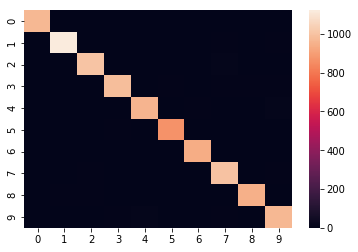

In [24]:
# 用估計值和真實值製作混淆矩陣
mat = confusion_matrix(y_pred, y_true)
print(mat)
# 用熱點圖可以清楚看出混淆矩陣的分布
sns.heatmap(mat)

我們透過混淆矩陣, 可以確認是不是有某一種類別分類特別不好.  
不過, 混淆矩陣並不能很好的表達到底模型好或不好, 真的很混淆.  
所以通常我們都會使用`分類報告 classification report`.  
實務上我們可能會特別重視分類是否正確(或錯誤), 因此可能需要調整`f1-score`計算.  
不過那太複雜了, 之後有碰到在寫.  

In [32]:
# 要記得關掉會話哦~
sess.close()